## setup

In [ ]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from typing import TypedDict, List
import pandas as pd

MAX_RETRIES = 3




load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

if not GROQ_API_KEY:
    raise ValueError("Missing GROQ_API_KEY in .env")

# Init LLM
llm = ChatGroq(model="llama-3.1-8b-instant", api_key=GROQ_API_KEY)


## Add graphstate

In [101]:
class TestGenState(TypedDict):
    requirement: str
    test_cases: List[str]
    attempt: int  


## Define the nodes

In [120]:
def parse_requirement(state: TestGenState) -> TestGenState:
    """
    Node: Parse Requirement
    Purpose: Prepare the requirement text for the LLM.
    Input: state['requirement'] (string)
    Output: state['requirement'] (string)
    """
    state['attempt'] = 0
    return {"requirement": state["requirement"]}

def generate_test_cases(state: TestGenState) -> TestGenState:
    """
    Node: Generate Positive Test Cases
    Purpose: Use LLM to generate structured positive test cases for a requirement.
    Input: state['requirement'] (string)
    Output: state['test_cases'] (list of JSON objects with fields: id, description, steps, expected, type)
    """
    
    prompt = """Generate 3 positive test cases for the requirement:
    {state['requirement']}

    Each test case must include the following fields:
    - id
    - description
    - steps
    - expected
    - type (positive)
    Return the test cases as a table.
    """
    resp = llm.invoke(prompt)

    return {"test_cases": resp.content.split("\n")}


def is_retry_needed(state: TestGenState) -> str:
    """Return continue if JSON invalid and attempts < MAX_RETRIES."""
    valid = True
    
    state["valid"] = valid
    if not valid and state["attempt"] < MAX_RETRIES:
        return  "continue"
    return "end"


## setup the graph

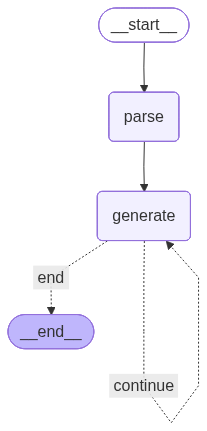

In [121]:
workflow = StateGraph(TestGenState)
workflow.add_node("parse", parse_requirement)
workflow.add_node("generate", generate_test_cases)

workflow.set_entry_point("parse")

# Normal flow
workflow.add_edge("parse", "generate")

# Retry flow
workflow.add_conditional_edges('generate', #Source Node
is_retry_needed, #Action
  {
    'continue': 'generate',
    'end': END
})


app = workflow.compile()
app

## Invoke the Graph

In [122]:
sample_req = {"requirement": "The system should allow login with username/password"}
result = app.invoke(sample_req)
result["test_cases"]


['| **Test Case ID** | **Description** | **Steps** | **Expected Result** | **Type** |',
 '| --- | --- | --- | --- | --- |',
 "| 1 | Test requirement with valid state | 1. Define a state with a valid 'requirement' key. 2. Pass the state to the function. 3. Verify the function returns the requirement. | The function returns the requirement. | Positive |",
 "| 2 | Test requirement with string value | 1. Define a state with a valid 'requirement' key and string value. 2. Pass the state to the function. 3. Verify the function returns the string value. | The function returns the string value. | Positive |",
 "| 3 | Test requirement with empty string value | 1. Define a state with a valid 'requirement' key and empty string value. 2. Pass the state to the function. 3. Verify the function returns the empty string. | The function returns the empty string. | Positive |"]

## print results nicely

In [116]:

df = pd.DataFrame({
    "Test Case": result["test_cases"]
})
df


,Test Case
0,```json
1,[
2,{
3,"""id"": 1,"
4,"""description"": ""Test case for a valid requ..."
5,"""steps"": ["
6,"""Create a state with a valid requirement"","
7,"""Call the function with the state"""
8,"],"
9,"""expected"": ""The function should return th..."
